<a href="https://colab.research.google.com/github/nirajneupane24/HybridEnergy/blob/master/today_Copy_of_Solar_Battery_gasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEW

In [ ]:
# pymoo used for optimization
from IPython.display import clear_output
!pip install pymoo
clear_output()

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymoo
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

In [ ]:
# reading the hourly energy csv file "contains hourly data for deficits, solar radiation and ambient air temperature(Jumla)"
df = pd.read_csv('HOURLY_DATA_new.csv')
# df = df[0:500]
'''
     csv file has deficit energy in MWh, solar radiation(ghi) in W/m2, air temperature in celcius.
    We perform the analysis in terms of KW.
'''
df['deficit_energy']=df['deficit_energy']*1000
df['deficit_energy'] = df['deficit_energy'].apply(lambda x: round(x, 6))
df['ghi']=df['ghi']/1000

In [ ]:
df.describe()

,Unnamed: 0,ghi,air_temperature,deficit_energy
count,183960.000000,183960.000000,183960.000000,1.839600e+05
mean,91979.500000,0.218271,11.596737,2.363686e+05
std,53104.822097,0.311458,8.223487,4.957133e+05
min,0.000000,0.000000,-8.630000,-1.302164e+06
25%,45989.750000,0.000000,4.888750,-1.272546e+05
50%,91979.500000,0.005384,12.802500,1.943938e+05
75%,137969.250000,0.403645,17.676667,5.229730e+05
max,183959.000000,1.147850,29.931667,2.140979e+06


In [ ]:
only_deficit = df['deficit_energy'].to_numpy()
only_deficit[only_deficit>0] = 0
print(only_deficit.sum())
total_deficit = -only_deficit.sum()
total_deficit

-16409703649.624172


16409703649.624172

In [ ]:
df['deficit_energy'].sum()

-16409703649.624172

In [ ]:
'''
    All the necessary constants required for modeling.
'''
N = 20 # project_life
i = 0.06 # interest_rate

solar_cost_unit = 727 # usd/kW(capex)
solar_OM = 4 # usd/kW.year(opex)

CRF = (i*((1+i)**N))/(((1+i)**N)-1) # capital recovery factor
d_f = 0.88 #derating_factor
Gt_stc = 1 #kw/m2
ap = -0.0035 #solar mod temp coeff of power(%/oC)
T_cstc = 25 #oC standard temp
NOCT = 45 #oC
n_bat = 0.92 #round trip efficieny

gasifier_cost_unit = 2300 # usd/kW(capex)
gasifier_OM = 2 # usd/kW.year(opex)
gasifier_CUF = 0.55 # capacity utilization factor

battery_cost_unit = 223.24 # usd/kW(capex)
battery_OM_per = 1.5 # 1.5% of capex annuity(opex)

In [ ]:
'''
    Calculating the Annualized system cost(ASC) and the levelised cost of energy(LCOE)
'''
def cost_pv(solar):
  solar_cost = solar*((CRF*solar_cost_unit)+solar_OM)
  return solar_cost

def cost_gasifier(gasifier):
  gasifier_cost = gasifier*((CRF*gasifier_cost_unit)+gasifier_OM)
  return gasifier_cost

def cost_battery(battery):
  battery_cap = battery*battery_cost_unit
  battery_op = battery_cap*CRF*battery_OM_per/100
  battery_cost = battery_cap*CRF+battery_op
  return battery_cost

# def LCOE(total_energy_prod, solar, gasifier, battery):
def LCOE(total_deficit, solar, gasifier, battery):
  ASC = cost_pv(solar)+cost_gasifier(gasifier)+cost_battery(battery)
  energy_prod_per_year = total_deficit/N
  lcoe = ASC/(energy_prod_per_year)
  return ASC, lcoe

In [ ]:
'''
    Calculating the energy produced by the solar panel and gasifier.
'''
def solar_ene_prod(solar_rate, solar_rad, temp):
  T_cell = temp+Gt_stc*((NOCT-20)/0.8)
  p_op = solar_rate*d_f*(solar_rad/Gt_stc)*(1+ap*(T_cell-T_cstc))
  return p_op

def gasifier_ene_prod(gasifier_rate):
  return gasifier_rate*gasifier_CUF

In [ ]:
'''
    Hybrid Energy system operational strategy
'''
def Energy_prod_(energy_def, battery_E, battery_max, solar_rate, solar_rad, gasifier_rate, temp):
  energy_def=-energy_def
  energy_prod = 0
  energy_served = 0
  solar_energy = 0
  gasifier_energy = 0
  battery_E_up = battery_E
  battery_supply = 0
  solar_energy = solar_ene_prod(solar_rate, solar_rad, temp)

  if energy_def>0:
    '''
    Energy deficit strategy
    '''
    if solar_energy-energy_def<0:
      '''
      Solar cannot fulfill the energy deficit.
      Run battery and gasifier.
      '''
      # req_energy needs to be addressed by gasifier and battery
      req_energy = energy_def-solar_energy
      energy_served+=solar_energy

      if battery_E>battery_max*0.3:
        if req_energy<=(battery_E-battery_max*0.3):
          '''
          req_energy met by only battery
          '''
          battery_supply = req_energy
          battery_E_up = battery_E-req_energy
          energy_served+=battery_supply

        else:
          '''
          req_energy met by battery and gasifier
          '''
          gasifier_E_req = req_energy-(battery_E-battery_max*0.3)
          battery_supply = battery_E-0.3*battery_max
          energy_served+=battery_supply
          battery_E_up = 0.3*battery_max
          gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

          if gasifier_energy_op>gasifier_E_req:
            gasifier_energy = gasifier_E_req
            energy_served+=gasifier_energy

          else:
            pass
            '''
            Hybrid energy system cannot fulfill the energy deficit.
            New hybrid combination required.
            '''
            # print("# THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

      else:
        '''
        req_energy met only by gasifier
        '''
        gasifier_energy_op = gasifier_ene_prod(gasifier_rate)

        if req_energy<gasifier_energy_op:
          gasifier_energy = req_energy
          energy_served+=gasifier_energy
        else:
          pass
          '''
          Hybrid energy system cannot fulfill the energy deficit.
          New hybrid combination required.
          '''
          # print("THE CURRENT SYSTEM RATING ISN'T ABLE TO FULLFIL THE DEFECIT, NEW HYBRID COMBINATION REQUIRED")

    else:
      '''
      Solar can fulfill the energy deficit.
      Extra energy from the solar panel is used to charge the battery.
      '''
      energy_served+=energy_def # solar panel served the entire deficit energy
      Pch_t = solar_energy-energy_def # extra energy from solar used for charging battery
      Ech_t = Pch_t*n_bat

      if Ech_t<=battery_max-battery_E:
        #battery isn't fully charged
        battery_E_up = battery_E+Ech_t

      else:
        #battery gets fully charged, E_dump is the remaining energy served to the grid
        battery_E_up = battery_max
        E_dump = Ech_t - (battery_max-battery_E)
        energy_served+=(E_dump/n_bat)
        Ech_t = battery_max-battery_E

    energy_prod = solar_energy + gasifier_energy

  else :
    '''
    Energy surplus strategy
    '''
    energy_prod=solar_energy+gasifier_energy
    surplus_ene = abs(energy_def)

    Pch_t = solar_energy
    Ech_t = Pch_t*n_bat

    if Ech_t<=battery_max-battery_E:
      battery_E_up = battery_E+Ech_t

    else:
      battery_E_up = battery_max
      E_dump = Ech_t - (battery_max-battery_E)
      energy_served+=(E_dump/n_bat)
      Ech_t = battery_max-battery_E

  return energy_served, battery_supply, battery_E_up, solar_energy, gasifier_energy

In [ ]:
'''
    Optimization for minimizing the LCOE.
'''
class ProblemWrapper(Problem):
  def _evaluate(self, designs, out, *args, **kwargs):
    res = []
    res1 =[]
    for design in designs:

      solar, gasifier, battery = design

      count = 0
      Energy_prod_N = 0 #total energy throughout the project life produced
      battery_E = battery

      for i in range(len(df)):
        n_battery_E = battery_E
        Energy_served,battery_supply, battery_E, _, _ = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
        Energy_prod_N += Energy_served
        energy_tot = df['deficit_energy'][i]+Energy_served
        energy_tot = round(energy_tot, 4)

        if energy_tot<0 and count!=1:
          count = 1
          break

      asc, lcoe = LCOE(total_deficit, solar, gasifier, battery)
      res.append(lcoe)
      res1.append(count)
    out['F']=np.array(res)
    out['H']=np.array(res1)

problem = ProblemWrapper(n_var=3, n_obj=1, n_eq_constr=1, xl=[0, 0, 0], xu=[7440937, 2360000, 7440937],vtype=int)

In [ ]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
algorithm = GA(pop_size=20,
               sampling=IntegerRandomSampling(),
               crossover=SBX(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               mutation=PM(prob=1.0, eta=3.0, vtype=int, repair=RoundingRepair()),
               eliminate_duplicate=True)
stop_criteria = ('n_gen', 50)

In [ ]:
%%time
results = minimize(problem=problem,
                   algorithm=algorithm,
                   termination=stop_criteria,
                   verbose=True,
                   seed=42,
                   save_history=True)

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       20 |  0.000000E+00 |  0.9499050000 |  1.2198360444 |  1.2198360444
     2 |       40 |  0.000000E+00 |  0.8999100000 |  1.2704055266 |  1.2198360444
     3 |       60 |  0.000000E+00 |  0.7999200000 |  1.2443539962 |  1.1998831138
     4 |       80 |  0.000000E+00 |  0.5999400000 |  1.2243329164 |  1.1184066988
     5 |      100 |  0.000000E+00 |  0.2499750000 |  1.2265286758 |  1.0997043725
     6 |      120 |  0.000000E+00 |  0.000000E+00 |  1.1819142822 |  1.0831043246
     7 |      140 |  0.000000E+00 |  0.000000E+00 |  1.1241670171 |  1.0682835585
     8 |      160 |  0.000000E+00 |  0.000000E+00 |  1.0926903176 |  0.9986275802
     9 |      180 |  0.000000E+00 |  0.000000E+00 |  1.0772375813 |  0.9986275802
    10 |      200 |  0.000000E+00 |  0.000000E+00 |  1.0614460477 |  0.9338312745
    11 |      220 |  0.000000E+00 |  0.000000E+00 |  1.0477818899 |  0.9338312745
    12 |      24

In [ ]:
'''
Optimized results for SOO.
'''
solar, gasifier, battery = results.X
print(f"Solar:{solar}KW, Gasifier: {gasifier}KW, Battery: {battery}KWh || LCOE: {results.F}USD/KWh")

Solar:2907308KW, Gasifier: 2214020KW, Battery: 4458279KWh || LCOE: [0.89260638]USD/KWh


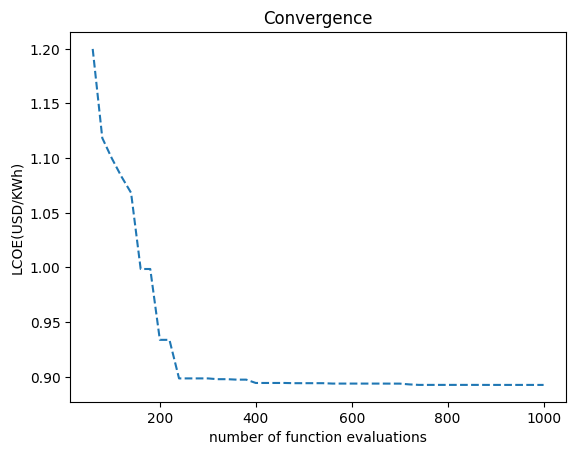

In [ ]:
'''
Convergence plot for SOO.
'''
import numpy as np
import matplotlib.pyplot as plt

n_evals = np.array([e.evaluator.n_eval for e in results.history])
opt = np.array([e.opt[0].F for e in results.history])

plt.title("Convergence")
plt.plot(n_evals[2:], opt[2:], "--")
plt.xlabel("number of function evaluations")
plt.ylabel("LCOE(USD/KWh)")
plt.show()

In [ ]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
# solar, gasifier, battery = results.X
solar, gasifier, battery = 3717620.230751795, 2209925.35022830, 4446649.505009017

# Solar:3717620.230751795KW, Gasifier: 2209925.350228307KW, Battery: 4446649.505009017KWh || LCOE: [0.12784646]USD/KWh

solar_array = []
gasifier_array = []
battery_array = []
battery_supply_array = []
deficit_array = []

total_supply = []

count = 0
gasifier_up_hr = 0
gasifier_energy = 0
Energy_prod_N = 0
battery_E = battery
# for i in range(len(df)):
for i in range(8760):

  # Energy_produced = Energy_prod(solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_served, battery_supply, battery_E, solar_ene, gasifier_ene = Energy_prod_(energy_def=df['deficit_energy'][i] ,battery_E=battery_E ,battery_max=battery, solar_rate=solar, solar_rad=df['ghi'][i], gasifier_rate=gasifier, temp=df['air_temperature'][i])
  Energy_prod_N += Energy_served
  gasifier_energy+=gasifier_ene

  if round(gasifier_ene, 2)>0:
    # print(gasifier_ene)
    # print(i)


    gasifier_up_hr+=1

  deficit_array.append(df['deficit_energy'][i])
  solar_array.append(solar_ene)
  gasifier_array.append(gasifier_ene)
  battery_supply_array.append(battery_supply)
  battery_array.append(battery_E)
  total_supply.append(battery_supply+gasifier_ene+solar_ene)
print(gasifier_up_hr)
print(gasifier_energy)
asc, lcoe = LCOE(Energy_prod_N, solar, gasifier, battery)
print(asc, lcoe)

1710
652537344.4901885
785912711.3029149 2.48182536396141


In [ ]:
640462667.4007576/2.75


232895515.4184573

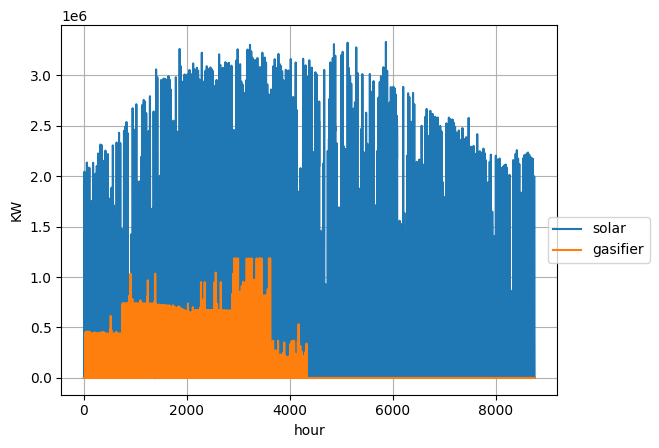

In [ ]:
'''
Viewing the operation of the optimized hybrid energy system.
'''
i = 0 # start hour
j = 8760 # end hour
x = np.arange(i,j)
plt.plot(x,solar_array[i:j], label='solar')
plt.plot(x,gasifier_array[i:j], label='gasifier')
# plt.plot(x,battery_array[i:j], label = 'battery-SOC')
# plt.plot(x,battery_supply_array[i:j], label = 'battery')
# plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit')
# plt.plot(x,-np.array(deficit_array[i:j]), label = 'deficit/surplus')
# plt.plot(x,np.array(deficit_array[i:j]), label = 'surplus')
plt.xlabel("hour")
plt.ylabel("KW")
# plt.plot(x,total_supply[i:j], label = 'total')
plt.grid()
plt.legend(loc='upper right',bbox_to_anchor=(1.2,0.5))